<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/RAG_ON_COMPLEX_PDF_Using_llamaparse_langchain_qdrant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install required dependencies

In [1]:
%%writefile requirements.txt
langchain
langchain-community
llama-parse
fastembed
chromadb
python-dotenv
langchain-groq
chainlit
fastembed
unstructured[md]


Writing requirements.txt


In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.8/276.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Download the content

In [3]:
!wget "https://github.com/sudarshan-koirala/RAG-chat-with-documents/blob/main/data/uber_10q_march_2022.pdf"

--2024-04-07 03:37:23--  https://github.com/sudarshan-koirala/RAG-chat-with-documents/blob/main/data/uber_10q_march_2022.pdf
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘uber_10q_march_2022.pdf’

uber_10q_march_2022     [ <=>                ] 145.86K   917KB/s    in 0.2s    

2024-04-07 03:37:24 (917 KB/s) - ‘uber_10q_march_2022.pdf’ saved [149360]



## Set up the environment varibales

In [4]:
from google.colab import userdata

llamaparse_api_key = userdata.get('LLAMA_CLOUD_API_KEY')

## Import required dependencies

In [5]:
##### LLAMAPARSE #####
from llama_parse import LlamaParse

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import DirectoryLoader
#
import joblib
import os
import nest_asyncio  # noqa: E402
nest_asyncio.apply()

## Process the data

In [6]:
!mkdir data

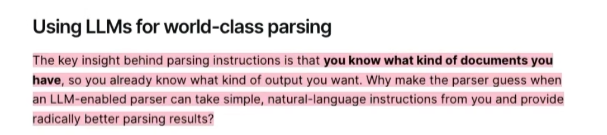

#### As per the free
* 7,000 free pages per week. Then $0.003
per page ($3 per 1,000 pages).
* 1000 pages per day

https://www.llamaindex.ai/blog/launching-the-first-genai-native-document-parsing-platform

## LlamaParse parameters

* api_key: str = Field(
  default="",
  
  description="The API key for the LlamaParse API.",

  )
    
* base_url: str = Field(
        default=DEFAULT_BASE_URL,
        description="The base URL of the Llama Parsing API.",
    )
* result_type: ResultType = Field(
        default=ResultType.TXT, description="The result type for the parser."
    )
* num_workers: int = Field(
        default=4,
        gt=0,
        lt=10,
        description="The number of workers to use sending API requests for parsing."
    )
* check_interval: int = Field(
        default=1,
        description="The interval in seconds to check if the parsing is done.",
    )
* max_timeout: int = Field(
        default=2000,
        description="The maximum timeout in seconds to wait for the parsing to finish.",
    )
* verbose: bool = Field(
        default=True, description="Whether to print the progress of the parsing."
    )
* language: Language  = Field(
         default=Language.ENGLISH, description="The language of the text to parse."
    )
* parsing_instruction: Optional[str] = Field(
        default="",
        description="The parsing instruction for the parser."
    )

In [7]:
def load_or_parse_data():
    data_file = "./data/parsed_data.pkl"

    if os.path.exists(data_file):
        # Load the parsed data from the file
        parsed_data = joblib.load(data_file)
    else:
        # Perform the parsing step and store the result in llama_parse_documents
        parsingInstructionUber10k = """The provided document is a quarterly report filed by Uber Technologies,
        Inc. with the Securities and Exchange Commission (SEC).
        This form provides detailed financial information about the company's performance for a specific quarter.
        It includes unaudited financial statements, management discussion and analysis, and other relevant disclosures required by the SEC.
        It contains many tables.
        Try to be precise while answering the questions"""
        parser = LlamaParse(api_key=llamaparse_api_key,
                            result_type="markdown",
                            parsing_instruction=parsingInstructionUber10k,
                            max_timeout=5000,)
        llama_parse_documents = parser.load_data("./data/uber_10q_march_2022 (1).pdf")


        # Save the parsed data to a file
        print("Saving the parse results in .pkl format ..........")
        joblib.dump(llama_parse_documents, data_file)

        # Set the parsed data to the variable
        parsed_data = llama_parse_documents

    return parsed_data

## Create Index

In [11]:
# Create vector database
from langchain_community.document_loaders import UnstructuredMarkdownLoader
def create_vector_database():
    """
    Creates a vector database using document loaders and embeddings.

    This function loads urls,
    splits the loaded documents into chunks, transforms them into embeddings using OllamaEmbeddings,
    and finally persists the embeddings into a Chroma vector database.

    """
    # Call the function to either load or parse the data
    llama_parse_documents = load_or_parse_data()
    print(llama_parse_documents[0].text[:300])

    with open('data/output.md', 'a') as f:  # Open the file in append mode ('a')
        for doc in llama_parse_documents:
            f.write(doc.text + '\n')

    markdown_path = "/content/data/output.md"
    loader = UnstructuredMarkdownLoader(markdown_path)

   #loader = DirectoryLoader('data/', glob="**/*.md", show_progress=True)
    documents = loader.load()
    # Split loaded documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=100)
    docs = text_splitter.split_documents(documents)

    #len(docs)
    print(f"length of documents loaded: {len(documents)}")
    print(f"total number of document chunks generated :{len(docs)}")
    #docs[0]

    # Initialize Embeddings
    embed_model = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5")

    # Create and persist a Chroma vector database from the chunked documents
    vs = Chroma.from_documents(
        documents=docs,
        embedding=embed_model,
        persist_directory="chroma_db_llamaparse1",  # Local mode with in-memory storage only
        collection_name="rag"
    )

    #query it
    #query = "what is the agend of Financial Statements for 2022 ?"
    #found_doc = qdrant.similarity_search(query, k=3)
    #print(found_doc[0][:100])
    #print(qdrant.get())

    print('Vector DB created successfully !')
    return vs,embed_model

## Process the data and create the vectorstore

In [12]:
vs,embed_model = create_vector_database()

# Uber Technologies, Inc. - Quarterly Report

# Uber Technologies, Inc. - Quarterly Report

Filed with the Securities and Exchange Commission (SEC)

## Form 10-Q

Quarterly Report Pursuant to Section 13 or 15(d) of the Securities Exchange Act of 1934

For the quarterly period ended March 31, 2022

#


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


length of documents loaded: 1
total number of document chunks generated :179


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

ort_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/218M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

Vector DB created successfully !


## Getting Started with  Groq API

Real-time AI systems rely heavily on fast inference. Inference APIs from industry leaders like OpenAI, Google, and Azure enable rapid decision-making. Groq’s Language Processing Unit (LPU) technology is a standout solution, enhancing AI processing efficiency.

## What is Groq ?

Groq is a California-based AI solutions startup founded in 2016 with its headquarters located in Mountain View. Groq, which specializes in ultra-low latency AI inference, has advanced AI computing performance significantly. Groq is a prominent participant in the AI technology space, having registered its name as a trademark and assembled a global team committed to democratizing access to AI.

## Features

* Groq’s Language Processing Unit (LPU), an innovative technology, aims to enhance AI computing performance, particularly for Large Language Models (LLMs). The Groq LPU system strives to deliver real-time, low-latency experiences with exceptional inference performance. Groq achieved over 300 tokens per second per user on Meta AI’s Llama-2 70B model, setting a new industry benchmark.

* Groq’s first-generation GroqChip, part of the LPU system, features a tensor streaming architecture optimized for speed, efficiency, accuracy, and cost-effectiveness. This chip surpasses incumbent solutions, setting new records in foundational LLM speed measured in tokens per second per user.

* The Groq LPU system boasts ultra-low latency capabilities crucial for AI support technologies. Specifically designed for sequential and compute-intensive GenAI language processing, it outperforms conventional GPU solutions, ensuring efficient processing for tasks like natural language creation and understanding.

## Getting Started with Groq
Right now, Groq is providing free-to-use API endpoints to the Large Language Models running on the Groq LPU – Language Processing Unit. To get started, visit this [page](https://console.groq.com/keys) and click on login. T

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

In [13]:
!pip install groq

## Instantiate LLM

In [14]:
# Importing Necessary Libraries
import os
from groq import Groq
from langchain_groq import ChatGroq

chat_model = ChatGroq(temperature=0,
                      model_name="mixtral-8x7b-32768",
                      api_key=userdata.get("GROQ_API_KEY"),)



The following line specifies the LLM to be used for generating the response, set to “mixtral-8x7b-32768,” a 32k context Mixtral-8x7b-Instruct-v0.1 Large language model accessible via the Groq API.

#### The above code does the following:

* Creates a new ChatGroq object named chat_model
* Sets the temperature parameter to 0, indicating that the responses should be more predictable
* Sets the model_name parameter to “mixtral-8x7b-32768“, specifying the language model to use

## Instantiate Vectorstore

In [16]:
 vectorstore = Chroma(embedding_function=embed_model,
                      persist_directory="chroma_db_llamaparse1",
                      collection_name="rag")
 #
 retriever=vectorstore.as_retriever(search_kwargs={'k': 3})

In [20]:
#vectorstore.get()

In [21]:
custom_prompt_template = """Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}
Question: {question}

Only return the helpful answer below and nothing else.
Helpful answer:
"""

In [22]:
from langchain.prompts import PromptTemplate
def set_custom_prompt():
    """
    Prompt template for QA retrieval for each vectorstore
    """
    prompt = PromptTemplate(template=custom_prompt_template,
                            input_variables=['context', 'question'])
    return prompt

In [23]:
prompt = set_custom_prompt()
prompt

PromptTemplate(input_variables=['context', 'question'], template="Use the following pieces of information to answer the user's question.\nIf you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nContext: {context}\nQuestion: {question}\n\nOnly return the helpful answer below and nothing else.\nHelpful answer:\n")

In [24]:
from langchain.chains import RetrievalQA
qa = RetrievalQA.from_chain_type(llm=chat_model,
                               chain_type="stuff",
                               retriever=retriever,
                               return_source_documents=True,
                               chain_type_kwargs={"prompt": prompt})

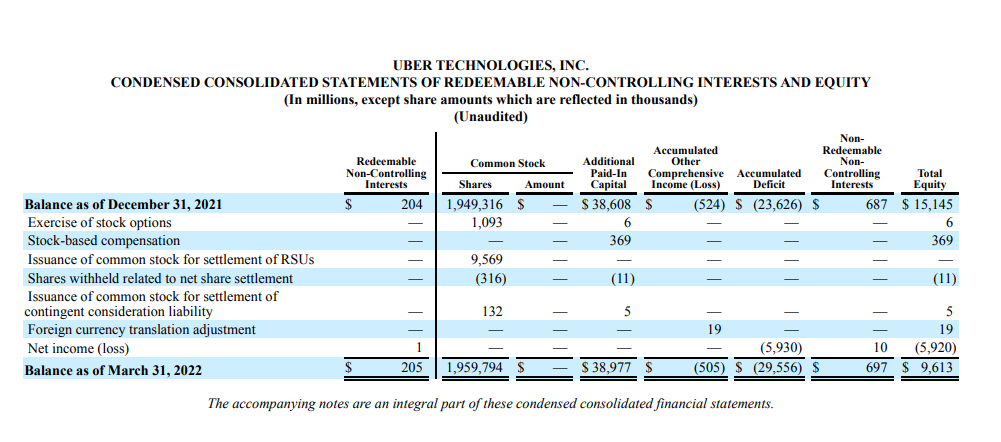

In [25]:
response = qa.invoke({"query": "what is the Balance of UBER TECHNOLOGIES, INC.as of December 31, 2021?"})

In [26]:
response

{'query': 'what is the Balance of UBER TECHNOLOGIES, INC.as of December 31, 2021?',
 'result': 'Based on the provided balance sheet of Uber Technologies, Inc. as of December 31, 2021, the total assets are $38,774 million, total liabilities are $23,425 million, and total equity is $9,613 million.',
 'source_documents': [Document(page_content="Uber Technologies, Inc. - Quarterly Report\n\nUber Technologies, Inc. - Condensed Consolidated Balance Sheets\n\nAssets As of December 31, 2021 As of March 31, 2022 Cash and cash equivalents $4,295 $4,184 Restricted cash and cash equivalents $631 $543 Accounts receivable $2,439 $2,476 Prepaid expenses and other current assets $1,454 $1,462 Total current assets $8,819 $8,665 Restricted cash and cash equivalents $2,879 $2,865 Investments $11,806 $6,247 Equity method investments $800 $624 Property and equipment, net $1,853 $1,853 Operating lease right-of-use assets $1,388 $1,439 Intangible assets, net $2,412 $2,269 Goodwill $8,420 $8,435 Other assets 

In [27]:
response['result']

'Based on the provided balance sheet of Uber Technologies, Inc. as of December 31, 2021, the total assets are $38,774 million, total liabilities are $23,425 million, and total equity is $9,613 million.'

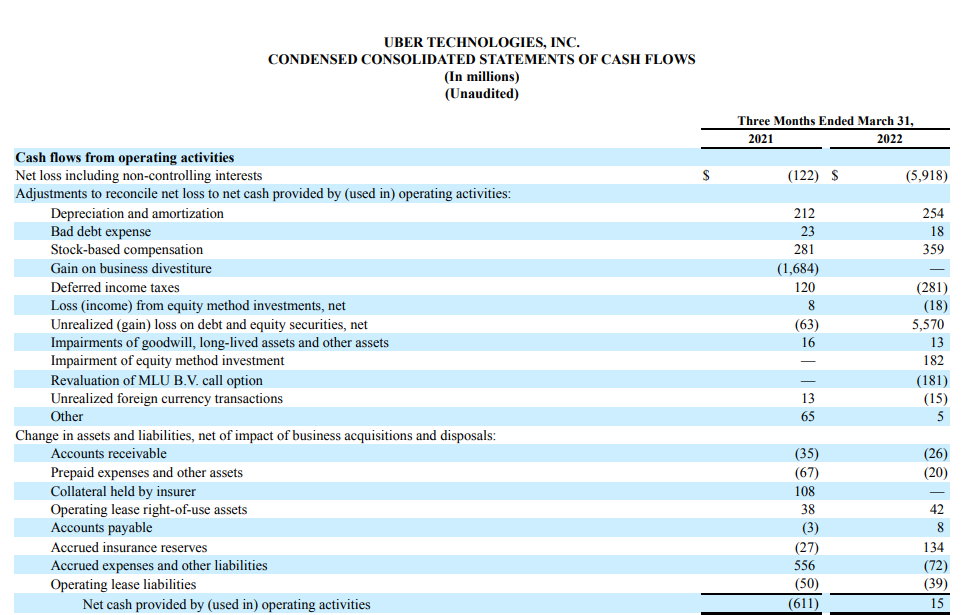

In [30]:
response = qa.invoke({"query": "What is the Cash flows from operating activities associated with bad expense specified in the document ?"})
response['result']

'The Cash flows from operating activities associated with bad debt expense is 23 for the year 2021 and 18 for the year 2022.'

In [49]:
response = qa.invoke({"query": "what is Loss (income) from equity method investments, net ?"})

In [50]:
response["result"]

'The loss from equity method investments, net, is calculated as the sum of the impairment of equity method investment and the revaluation of MLU B.V. call option, which amounted to $182 million and $181 million, respectively. This results in a total loss from equity method investments, net, of $363 million. This loss is included in the net loss attributable to Uber Technologies, Inc. of $5.9 billion.'

In [51]:
response["source_documents"][0]

Document(page_content='Various factors contributed to the significant change in other income (expense), net, with some items showing substantial gains or losses.\n\nUber Quarterly Report\n\nUber Technologies, Inc. - Quarterly Report\n\nGain on business divestiture decreased primarily due a $1.6 billion gain on the sale of our ATG Business to Aurora recognized in the first quarter of 2021. For additional information, refer to Note 15 – Divestiture in the notes to the condensed consolidated financial statements included in Part I, Item 1, of this Quarterly Report on Form 10-Q.\n\nUnrealized gain (loss) on debt and equity securities, net decreased by $5.6 billion primarily due to changes in the fair value of our marketable equity securities, including: a $1.9 billion unrealized loss on our Grab investment; a $1.7 billion unrealized loss on our Aurora investments; a $1.4 billion unrealized loss on our Didi investment; and a $462 million unrealized loss on our Zomato investment.\n\nImpairme

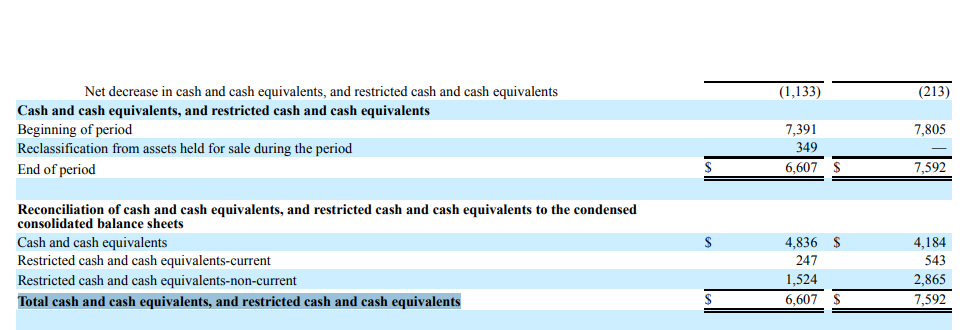

In [55]:
response = qa.invoke({"query": "What is the Total cash and cash equivalents, and restricted cash and cash equivalents for reconciliation ?"})
response['result']

'The total cash and cash equivalents, and restricted cash and cash equivalents for reconciliation is $6,607 million. This amount is obtained by adding the cash and cash equivalents of $4,836 million and the restricted cash and cash equivalents - current of $247 million, and the restricted cash and cash equivalents - non-current of $1,524 million.'

In [56]:
response["source_documents"][0]

Document(page_content='Effect of exchange rate changes on cash and cash equivalents, and restricted cash and cash equivalents\n|(46)|20|\n|---|---|\n\nUber Technologies, Inc. Quarterly Report\n\nNet Decrease in Cash and Cash Equivalents\n\nFor the period, there was a net decrease in cash and cash equivalents, and restricted cash and cash equivalents of $1,133.\n\nCash and Cash Equivalents Summary\n\nBeginning of Period Reclassification End of Period Cash and Cash Equivalents $7,391 $349 $6,607 Restricted Cash and Cash Equivalents - Current $7,805 - $7,592\n\nReconciliation of Cash and Cash Equivalents\n\nAmount Cash and Cash Equivalents $4,836 Restricted Cash and Cash Equivalents - Current $247 Restricted Cash and Cash Equivalents - Non-Current $1,524 Total $6,607\n\nSupplemental Disclosures\n\nAmount Cash Paid for Interest (net of amount capitalized) $84 Cash Paid for Income Taxes (net of refunds) $22 Non-Cash Investing and Financing Activities: Finance Lease Obligations $21 Non-Cash 

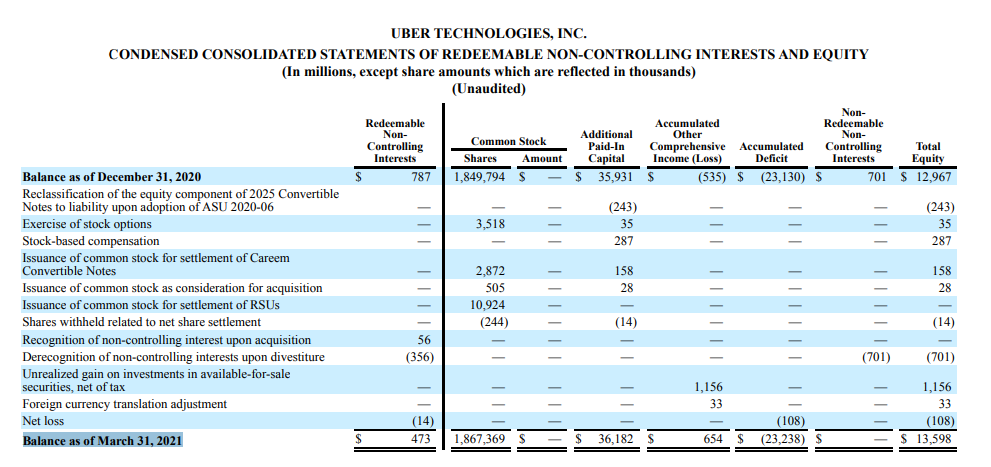

In [59]:
response = qa.invoke({"query":"Based on the CONDENSED CONSOLIDATED STATEMENTS OF REDEEMABLE NON-CONTROLLING INTERESTS AND EQUITY what is the Balance as of March 31, 2021?"})
print(response['result'])

The balance as of March 31, 2021 was $473 for Redeemable Non-Controlling Interests, 1,867,369 shares for Common Stock, $— for Additional Paid-In Capital, $36,182 for Other Comprehensive Income (Loss), $654 for Non-Controlling Interests, and $654 for Total Equity.


In [61]:
response["source_documents"][0].page_content

'Redeemable Non-Controlling Interests Common Stock Additional Paid-In Capital Other Comprehensive Income (Loss) Accumulated Deficit Redeemable Non-Controlling Interests Total Equity Balance as of December 31, 2021 $204 1,949,316 shares $38,608 ($524) ($23,626) $687 $15,145 Exercise of stock options - 1,093 shares $6 - - - $6 Stock-based compensation - - $369 - - - $369 Issuance of common stock for settlement of RSUs - 9,569 shares - - - - - Shares withheld related to net share settlement - (316 shares) ($11) - - - ($11) Issuance of common stock for settlement of contingent consideration liability - 132 shares $5 - - - $5 Foreign currency translation adjustment - - - - $19 - $19 Net income (loss) $1 - - - - $10 ($5,920) Balance as of March 31, 2022 $205 1,959,794 shares $38,977 ($505) ($29,556) $697 $9,613\n\nThe accompanying notes are an integral part of these condensed consolidated financial statements.\n\nUber Technologies, Inc. - Condensed Consolidated Statements of Cash Flows\n\nUb

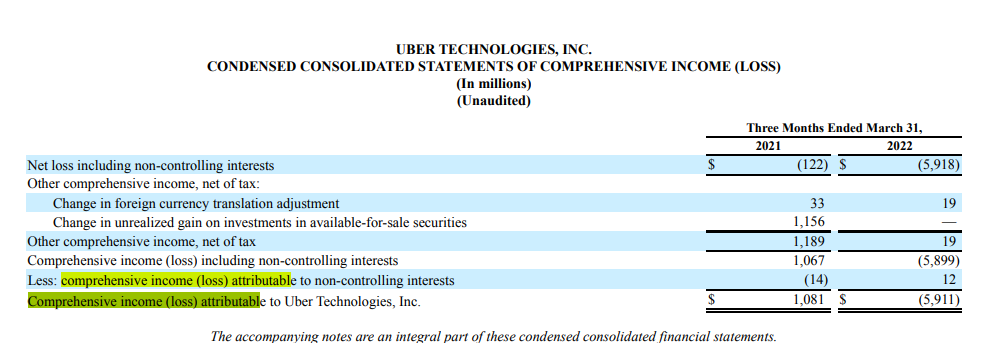

In [62]:
response = qa.invoke({"query":"Based on the condensed consolidated statements of comprehensive Income(loss) what is the  Comprehensive income (loss) attributable to Uber Technologies, Inc.for the three months ended March 31, 2022"})
response['result']

'The Comprehensive income (loss) attributable to Uber Technologies, Inc. for the three months ended March 31, 2022 was $(5,911) million. This information can be found on the Uber Technologies, Inc. - Condensed Consolidated Statements of Comprehensive Income (Loss) provided in the quarterly report.'

In [63]:
response = qa.invoke({"query":"Based on the condensed consolidated statements of comprehensive Income(loss) what is the  Comprehensive income (loss) attributable to Uber Technologies?"})
response['result']

'The Comprehensive income (loss) attributable to Uber Technologies, Inc. for the three months ended March 31, 2021 is $1,081 million, and for the three months ended March 31, 2022 is -$5,911 million.'

In [64]:
response = qa.invoke({"query":"Based on the condensed consolidated statements of comprehensive Income(loss) what is the Net loss including non-controlling interests"})

In [65]:
response['result']

'The Net loss including non-controlling interests is $(122) million for the three months ended March 31, 2021 and $(5,918) million for the three months ended March 31, 2022.'

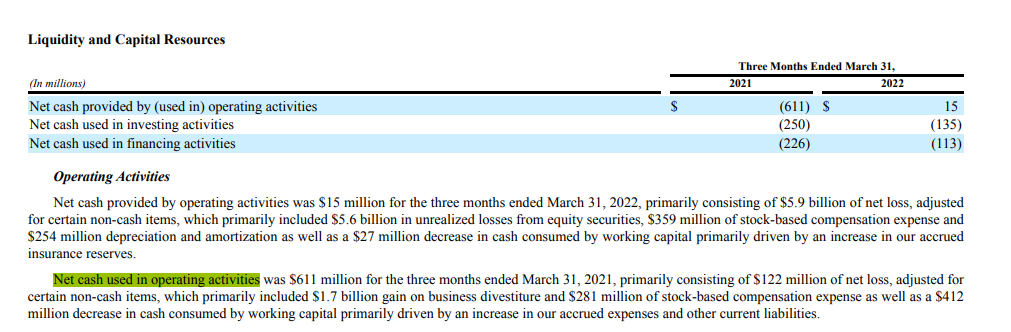

In [66]:
response = qa.invoke({"query":"what is the Net cash used in operating activities for Mrach 31,2021? "})
response['result']

'Net cash used in operating activities for March 31, 2021 was $611 million.'

In [67]:
response["source_documents"][0].page_content

'Intangible Assets Summary (March 31, 2022)\n| |Gross Carrying Value|Accumulated Amortization|Net Carrying Value|Useful Life (Years)|\n|---|---|---|---|---|\n|Consumer, Merchant and other relationships|$1,856|$(362)|$1,494|9|\n|Developed technology|$924|$(325)|$599|5|\n|Trade names and trademarks|$222|$(55)|$167|6|\n|Patents|$15|$(8)|$7|6|\n|Other|$5|$(3)|$2|0|\n\nAmortization expense for intangible assets subject to amortization was $92 million and $144 million for the three months ended March 31, 2021 and 2022, respectively.\n\nThe estimated aggregate future amortization expense for intangible assets subject to amortization as of March 31, 2022 is summarized below (in millions):\n\nEstimated Future Amortization Expense\n|Year Ending December 31|Estimated Future Amortization Expense|\n|---|---|\n|Remainder of 2022|$381|\n|2023|$363|\n|2024|$306|\n|2025|$266|\n|2026|$203|\n|Thereafter|$748|\n|Total|$2,267|\n\nUber Technologies, Inc. - Long-Term Debt and Revolving Credit Arrangements\n\

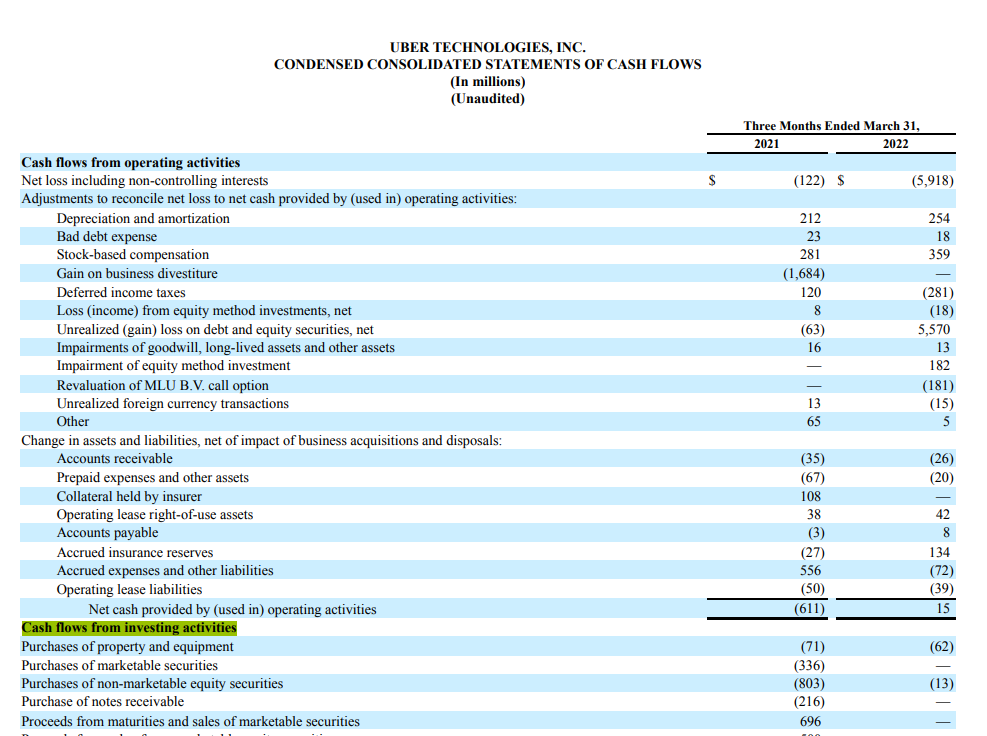

In [71]:
query = "Based on the CONDENSED CONSOLIDATED STATEMENTS OF CASH FLOWS What is the value of Purchases of property and equipment ?"
response = qa.invoke({"query":query})
response['result']

"The value of purchases of property and equipment for the three months ended March 31, 2021 and 2022 can be found in the 'Cash flows from investing activities' section of the condensed consolidated statements of cash flows.\n\nFor the three months ended March 31, 2021: $71 million\nFor the three months ended March 31, 2022: $62 million"

In [73]:
response["source_documents"][0].page_content

'Basis of Presentation\n\nThe accompanying unaudited condensed consolidated financial statements have been prepared in accordance with generally accepted accounting principles in the United States (“GAAP”) and applicable rules and regulations of the Securities and Exchange Commission (“SEC”) regarding interim financial reporting. The condensed consolidated balance sheet as of December 31, 2021 included herein was derived from the audited consolidated financial statements as of that date. Certain information and note disclosures normally included in the financial statements prepared in accordance with GAAP have been condensed or omitted pursuant to such rules and regulations. As such, the information included in this Quarterly Report on Form 10-Q should be read in conjunction with the audited consolidated financial statements and the related notes thereto as of and for the year ended December 31, 2021, included in our Annual Report on Form 10-K. The results for the interim periods are n

In [78]:
query = "Based on the CONDENSED CONSOLIDATED STATEMENTS OF CASH FLOWS what is the Purchases of property and equipment for the year 2022?"
response = qa.invoke({"query":query})
response['result']

'The purchases of property and equipment for the year 2022 based on the CONDENSED CONSOLIDATED STATEMENTS OF CASH FLOWS is -62.'